# Initialiazation Packages

In [1]:
using LinearAlgebra
using PyPlot
using PyCall
using LaTeXStrings
using QuantumToolbox,DifferentialEquations
using DelimitedFiles, NLsolve
using Random, Distributions, Dates, Polynomials, StatsBase 
using JLD

In [2]:
#using Pkg
#Pkg.activate("..")

include("../src/Classical_2KPOs_functions.jl")
using .Classical_KPOs

## Poincaré section of the classical trajectories

In [3]:
#KPOs parameters
Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ = 0., 1., 0., 5., 0., 1., 0., 5., 1.0;
println("KPOs parameters: ", (Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ))
min_ics = 10

KPOs parameters: (0.0, 1.0, 0.0, 5.0, 0.0, 1.0, 0.0, 5.0, 1.0)


10

Generating ICs from Closed system sweeping Energy

In [24]:
#KPOs parameters
roots_,E_cl, λs, s_λs = Classical_KPOs.crit_energies((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, 0.), 10)
E_cat = E_cl[1]
min_ics = 100
println("Kerr-cat energy: ", E_cat)
γs = [1.0, 5.0, 10.0]
println("Coupling values: ", γs)

Kerr-cat energy: -50.0
Coupling values: [1.0, 5.0, 10.0]


In [25]:
function Poincare_p2_0(E, q_l, q_r, p, p2_pos=false; min_ics=100, max_attempts=100_000, timeout_seconds=10)
    ICs = generate_initial_conditions_p2_0(E, q_l, q_r, p; min_ics=min_ics, max_attempts=max_attempts, timeout_seconds=timeout_seconds)
    n_ICs = size(ICs)[1]
    λ_maxs = zeros(n_ICs)
    
    println("Number of ICs: ", n_ICs)
    function linear_interp(x,x1,y1,x2,y2)
        return ((x-x1)/(x2-x1))*y2 + ((x2-x)/(x2-x1))*y1
    end  
    function t_y0(t1,t2,y1,y2)
        return (y2*t1 - y1*t2)/(y2-y1)
    end
    final_points = 0. #just to have a variable after the loop
    
    for i in 1:n_ICs
        prob = ODEProblem(EqM!, ICs[i], (0.0, N*Δt),saveat = Δt, p)
        sol = solve(prob, Tsit5(), abstol=1e-7, reltol=1e-7, maxiters=N*1000)
        traj = sol.u

        #getting just the p2 column
        comp_sol = sol[4,1,:]
        #Finding crossing points of p2 = 0
        poi_all =  comp_sol[2:end-1] .* comp_sol[3:end] .<= 0
        # just positive p2
        if p2_pos == true
            poi_pos = sol[4,1,:][2:end-1] .>= 0
            #Crossings at q2 = 0 with positive p2 
            poi_pos = poi_pos .& poi_all
        else
            poi_pos = poi_all
        end
        #In between times of zeros
        t_ini = (0:Δt:N*Δt)[2:end-1][poi_pos] #times + for zeros
        t_end = (0:Δt:N*Δt)[3:end][poi_pos] # times - for zeros
        comp_ini = comp_sol[2:end-1][poi_pos] #p2 positive zero
        comp_end = comp_sol[3:end][poi_pos] #p2 negatie zero
        t_values=  @. t_y0(t_ini, t_end, comp_ini, comp_end) #Interpolation

        dim_sols = size(t_values)[1]
        solutions = zeros(dim_sols,4)
        for component in [1,2,3] #q1,p1,q2 
            comp_ini = sol[component,1,:][2:end-1][poi_pos]
            comp_end = sol[component,1,:][3:end][poi_pos]
            interp_values = @. linear_interp( t_values, t_ini, comp_ini, t_end, comp_end)
            solutions[:,component] = interp_values
        end

        if i == 1
            final_points = copy(solutions)
        else
            final_points = vcat(final_points, solutions)
        end
    end
    return final_points
end

Poincare_p2_0 (generic function with 2 methods)

In [26]:
N = Int(2e3);
Δt = 1e-2; #smallest time inteval for the Lapunov calculation
q_l,q1_r, q2_l,q_r = -10, 10, -10, 10#-5., 5., -5., 5.
n_p = 3
final_points_list = [zeros(1,1) for i in 1:n_p]
min_ics_list = [100, 100, 100]
for i in 1:n_p
    p =  Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γs[i]
    final_points = Poincare_p2_0(E_cat, q_l, q1_r, p, false,  min_ics=min_ics_list[i]);
    final_points_list[i] = final_points
end

Number of ICs: 100
Number of ICs: 100
Number of ICs: 100


In [27]:
function plot_Poinc()
    fig = figure(figsize=(15, 5), layout="constrained")
    gs = fig.add_gridspec(1,3)
    #gs = fig.add_gridspec(2,5)
    element(i,j) = get(gs, (i,j)) # starts at 0 to N-1
    slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j)
                    
    for i in 1:n_p
        ax = fig.add_subplot(element(0,i-1))
        scat_plot = ax.scatter(final_points_list[i][:,1], final_points_list[i][:,3], s = 0.1, color="black")
        #=
        ax.set_ylim(-2,2)
        yticks([-2,-1, 0,1,2], fontsize = 15)
        if i == 1
            ax.set_ylabel(L"p_1",fontsize=20)
        else
            yticks([])
        end
        if i ==1
            ax.text(.38, 0.95, L"γ = %$(ps[i])", transform=ax.transAxes, fontsize=20, verticalalignment="top")
        else 
            ax.text(.4, 0.95, L"γ = %$(ps[i])", transform=ax.transAxes, fontsize=20, verticalalignment="top")

        end
        ax.set_xlim(-5.5,5.5)
        xticks([-5,-2.5,0,2.5,5], fontsize = 15)
        =#
        ax.set_xlabel(L"q_1",fontsize=20)
        title(L"γ = %$(γs[i])",fontsize=20)
    end
    
end

plot_Poinc (generic function with 1 method)

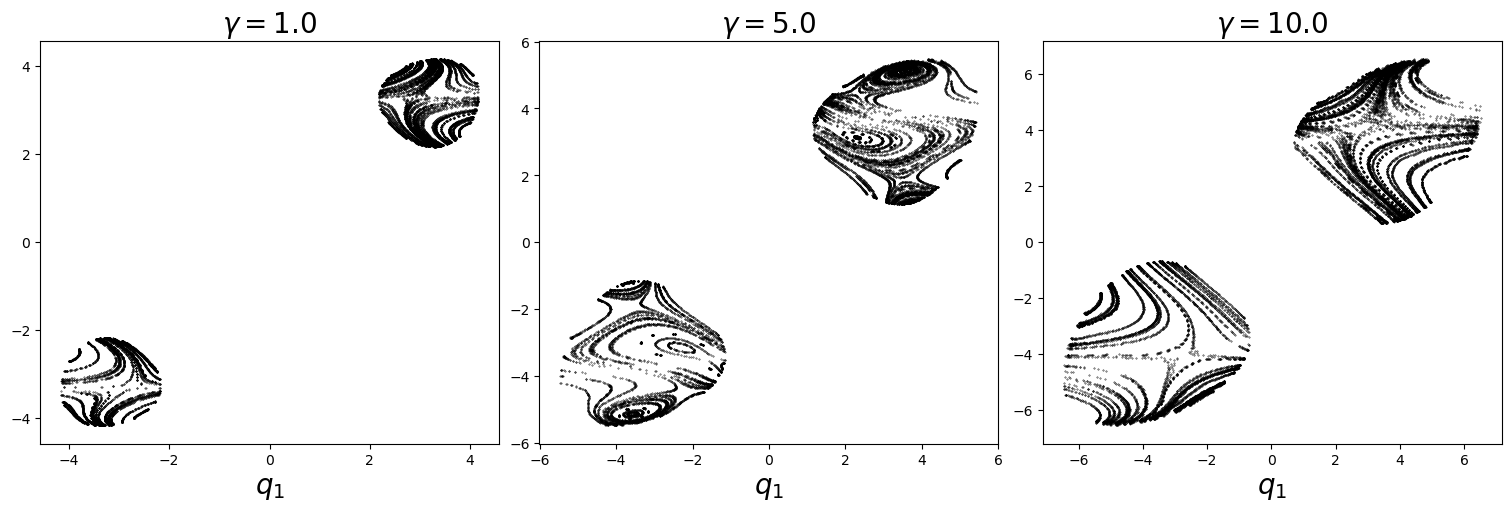

In [28]:
plot_Poinc()

In [20]:
function plot_Poinc3D()
    fig = figure(figsize=(30, 10), layout="constrained")
    gs = fig.add_gridspec(1,3)
    #gs = fig.add_gridspec(2,5)
    element(i,j) = get(gs, (i,j)) # starts at 0 to N-1
    slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j)
                    
    for i in 1:n_p
        ax = fig.add_subplot(element(0,i-1),projection="3d")
        ax.view_init(elev=10, azim=280)
        scat_plot = ax.scatter(final_points_list[i][:,1], final_points_list[i][:,2], final_points_list[i][:,3], s = 0.1, color="black")
        #=
        ax.set_ylim(-2,2)
        yticks([-2,-1, 0,1,2], fontsize = 15)
        if i == 1
            ax.set_ylabel(L"p_1",fontsize=20)
        else
            yticks([])
        end
        if i ==1
            ax.text(.38, 0.95, L"γ = %$(ps[i])", transform=ax.transAxes, fontsize=20, verticalalignment="top")
        else 
            ax.text(.4, 0.95, L"γ = %$(ps[i])", transform=ax.transAxes, fontsize=20, verticalalignment="top")

        end
        ax.set_xlim(-5.5,5.5)
        xticks([-5,-2.5,0,2.5,5], fontsize = 15)
        =#
        ax.set_xlabel(L"q_1",fontsize=20)
        ax.set_ylabel(L"p_1",fontsize=20)
        ax.set_zlabel(L"q_2",fontsize=20)
        title(L"γ = %$(γs[i])",fontsize=20)
    end
    
end

plot_Poinc3D (generic function with 1 method)

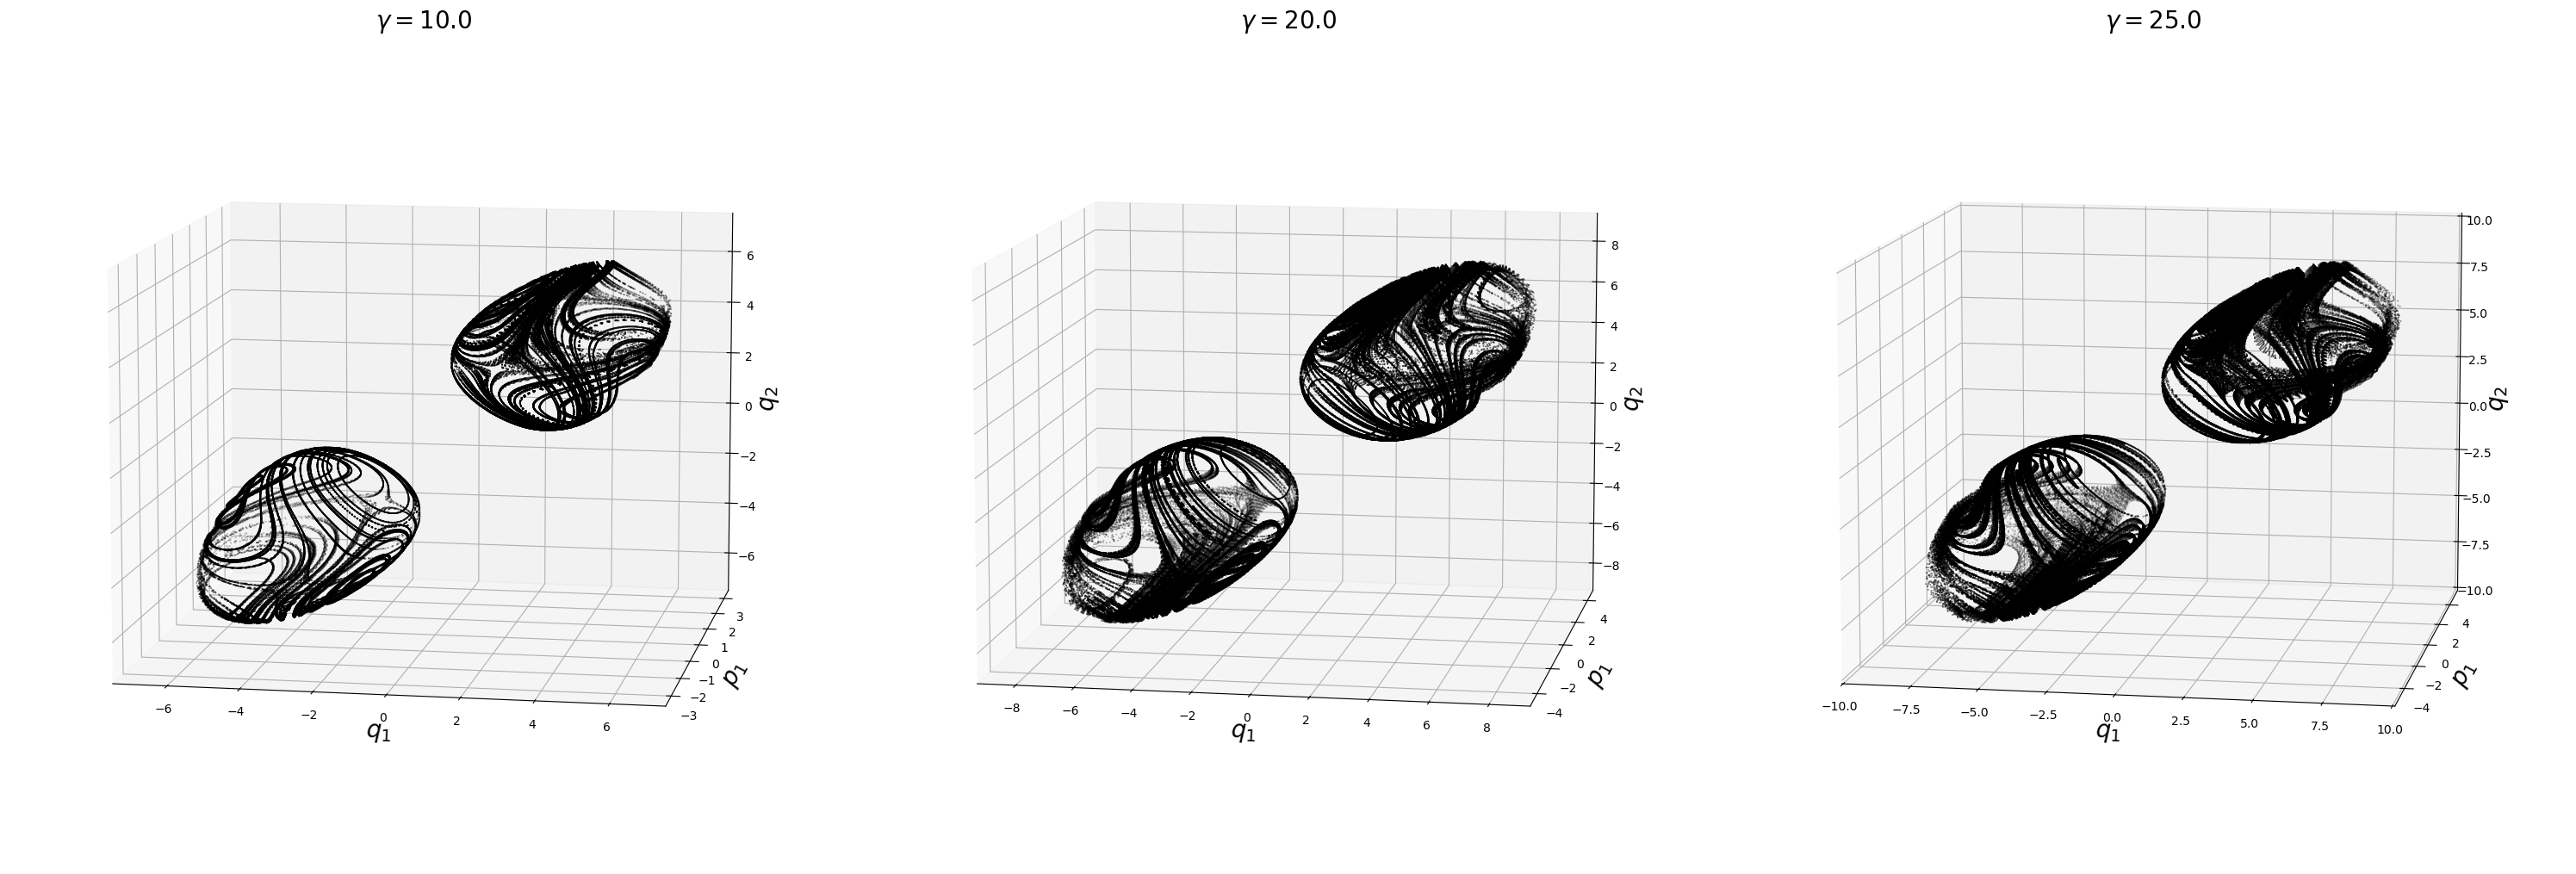

In [21]:
plot_Poinc3D()